In [1]:
import pandas as pd

In [2]:
import altair as alt

In [3]:
import sweetviz as sv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns

In [4]:
train_df=pd.read_csv("G:\\AV\\train_s3TEQDk.csv")
test_df=pd.read_csv("G:\\AV\\test_mSzZ8RL.csv")

In [31]:
feature_config = sv.FeatureConfig(skip="ID")

In [43]:
my_report = sv.compare([train_df, "Training Data"], [test_df, "Test Data"],"Is_Lead",feature_config)

In [196]:
train_df

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


In [38]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [47]:
train_df.columns,test_df.columns

(Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
        'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
        'Is_Lead'],
       dtype='object'),
 Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
        'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
       dtype='object'))

In [5]:
class feature_eng():
    
    def __init__(self):
        pass
    def feature_cleaning(self,df):
        df_copy=df.copy()
        df_copy['Credit_Product']=df_copy.Credit_Product.fillna("NOT")
        df_copy['Is_Active']=df_copy['Is_Active'].apply(lambda x: {'Yes':1,'No':0}[x])
        df_copy['Gender']=df_copy['Gender'].apply(lambda x: {'Female':1,'Male':0}[x])
        
        encoding_cols=['Occupation','Channel_Code','Credit_Product','Region_Code']
        other_cols=['Gender','Is_Active','Age','Avg_Account_Balance','Vintage']
        
        encoded_list=[]
        for j in encoding_cols:
            encoded_list.append(pd.get_dummies(df_copy[j],prefix=j))
        
        for k in other_cols:
            encoded_list.append(df_copy[k])
            
        final_df=pd.concat(encoded_list,axis=1)
        final_df['log_age']=np.log(final_df.Age)
        final_df['log_vintage']=np.log(final_df.Vintage)
        final_df['log_Avg_Account_Balance']=np.log(final_df.Avg_Account_Balance)
        
        return final_df
    
    def normalize_features(self,df):
        df_copy=df.copy()
        
        
        def noramlize_age(x):
            indx=int(x['age_cluster'])
        #     print((x['log_age']-gm.means_[indx][0]),gm.covariances_[indx][0])
            return (x['log_age']-self.age_gm.means_[indx][0])/self.age_gm.covariances_[indx][0][0]
        
        df_copy['age_cluster']=self.age_gm.predict(np.log(df_copy.Age.values).reshape(-1, 1))
        df_copy['age_normalized']=df_copy.apply(lambda x:noramlize_age(x),axis=1 )
        
        def noramlize_vintage(x):
            indx=int(x['vintage_cluster'])
        #     print((x['log_age']-gm.means_[indx][0]),gm.covariances_[indx][0])
            return (x['log_vintage']-self.vintage_gm.means_[indx][0])/self.vintage_gm.covariances_[indx][0][0]
        
        df_copy['vintage_cluster']=self.vintage_gm.predict(np.log(df_copy.Vintage.values).reshape(-1, 1))
        df_copy['Vintage_normalized']=df_copy.apply(lambda x:noramlize_vintage(x),axis=1 )

        df_copy['Avg_Account_Balance_normalized']=(df_copy['log_Avg_Account_Balance']-self.avg_bal_mean)/self.avg_bal_std
        
        return df_copy
    
    def fit(self,df_for_fit):
        self.train_df=df_for_fit
    
        self.train_df=self.train_df.set_index('ID')
        
        self.train_df_processed=self.feature_cleaning(self.train_df)
        
        self.age_gm = GaussianMixture(n_components=2, random_state=0).fit(np.log(self.train_df_processed.Age.values).reshape(-1, 1))
        self.vintage_gm = GaussianMixture(n_components=3, random_state=0).fit(np.log(self.train_df_processed.Vintage.values).reshape(-1, 1))
        
        self.avg_bal_mean=self.train_df_processed['log_Avg_Account_Balance'].mean()
        self.avg_bal_std=self.train_df_processed['log_Avg_Account_Balance'].std()
        
        
    def transform(self,trans_df):
        self.trans_df_processed=self.feature_cleaning(trans_df)
        self.trans_df_processed=self.normalize_features(self.trans_df_processed)
        
        return self.trans_df_processed
        
        
        
        
        

In [9]:

fe=feature_eng()

In [10]:
fe.fit(train_df)

In [11]:
train_df_processed=fe.transform(train_df)
test_df_processed=fe.transform(test_df)

In [12]:
reg_code=['Region_Code_RG250',
       'Region_Code_RG251', 'Region_Code_RG252', 'Region_Code_RG253',
       'Region_Code_RG254', 'Region_Code_RG255', 'Region_Code_RG256',
       'Region_Code_RG257', 'Region_Code_RG258', 'Region_Code_RG259',
       'Region_Code_RG260', 'Region_Code_RG261', 'Region_Code_RG262',
       'Region_Code_RG263', 'Region_Code_RG264', 'Region_Code_RG265',
       'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG268',
       'Region_Code_RG269', 'Region_Code_RG270', 'Region_Code_RG271',
       'Region_Code_RG272', 'Region_Code_RG273', 'Region_Code_RG274',
       'Region_Code_RG275', 'Region_Code_RG276', 'Region_Code_RG277',
       'Region_Code_RG278', 'Region_Code_RG279', 'Region_Code_RG280',
       'Region_Code_RG281', 'Region_Code_RG282', 'Region_Code_RG283',
       'Region_Code_RG284']
train_idv_cols=['Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X1', 'Channel_Code_X2',
       'Channel_Code_X3', 'Channel_Code_X4', 'Credit_Product_NOT',
       'Credit_Product_No', 'Credit_Product_Yes', 'Gender', 'Is_Active', 'age_cluster',
       'age_normalized', 'vintage_cluster', 'Vintage_normalized',
       'Avg_Account_Balance_normalized']+reg_code


target_col='Is_Lead'
train_y=train_df[target_col]

In [13]:
train_df_processed.columns

Index(['Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X1', 'Channel_Code_X2',
       'Channel_Code_X3', 'Channel_Code_X4', 'Credit_Product_NOT',
       'Credit_Product_No', 'Credit_Product_Yes', 'Region_Code_RG250',
       'Region_Code_RG251', 'Region_Code_RG252', 'Region_Code_RG253',
       'Region_Code_RG254', 'Region_Code_RG255', 'Region_Code_RG256',
       'Region_Code_RG257', 'Region_Code_RG258', 'Region_Code_RG259',
       'Region_Code_RG260', 'Region_Code_RG261', 'Region_Code_RG262',
       'Region_Code_RG263', 'Region_Code_RG264', 'Region_Code_RG265',
       'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG268',
       'Region_Code_RG269', 'Region_Code_RG270', 'Region_Code_RG271',
       'Region_Code_RG272', 'Region_Code_RG273', 'Region_Code_RG274',
       'Region_Code_RG275', 'Region_Code_RG276', 'Region_Code_RG277',
       'Region_Code_RG278', 'Region_Code_RG279', 'Region_Code_RG280',
       'Regi

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [16]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [20]:
import lightgbm as lgb

In [90]:
scores=[]

In [113]:
maxx=0
max_param=0
bst_com=[]

In [115]:

for num_leaves in range(1000,5000,500):
    for max_dept in range(500,2000,200):
        for learning_rate in range(1,10):
            for num_round in range(100,2000,100):
                for max_bin in range(250,1000,50):
                    lr=learning_rate/10
                    param={'num_leaves': num_leaves,
                             'objective': 'binary',
                             'max_depth': max_dept,
                             'verbosity': -1,
                             'learning_rate': lr,
                             'metric': 'auc',
                          'num_iterations':num_round,'max_bin':max_bin }
                    train_data = lgb.Dataset(x, label=y)

                    cv_bst=lgb.cv(param, train_data,  num_boost_round=num_round, nfold=10, early_stopping_rounds=5)


                    print(param,cv_bst['auc-mean'][-1])
                    print(bst_com)
                    param['score']=cv_bst
                    param['num_round']=num_round
                    if cv_bst['auc-mean'][-1]>maxx:
                        maxx=cv_bst['auc-mean'][-1]
                        max_param=param
                        bst_com=param,cv_bst['auc-mean'][-1]
                    scores.append(param)


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 250} 0.8706864517441938
[]


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 250, 'score': {'auc-mean': [0.8664409250048525, 0.8686662052158045, 0.8694976201216665, 0.8697274614595477, 0.8702348739102244, 0.8702871989577436, 0.8704595418678149, 0.8705369207476489, 0.8706360254281218, 0.8706695732869599, 0.870644047679645, 0.8706864517441938], 'auc-stdv': [0.002746647547693891, 0.0026100679905351836, 0.002348703086607543, 0.002433374579934804, 0.002440415368507826, 0.0024318970214624886, 0.002601886696854023, 0.002573277119065549, 0.0025503664180137743, 0.0024889275829748656, 0.0024145806156399396, 0.0023843270851885427]}, 'num_round': 100}, 0.8706864517441938)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 300, 'score': {'auc-mean': [0.8663898815539752, 0.8687741891540617, 0.869527349542244, 0.8698498183047946, 0.8703346079791467, 0.8704322952417174, 0.8705548086022962, 0.870690680634549, 0.8706858140785677, 0.87078810014241, 0.8708652040487077], 'auc-stdv': [0.0024376988803734073, 0.00219076872080463, 0.0022084424443004373, 0.0020810742265708368, 0.0020714529901617426, 0.0021600351038604765, 0.0023898675084802973, 0.002431799344261049, 0.0024659942946118315, 0.002422358867610798, 0.002341714531694058]}, 'num_round': 100}, 0.8708652040487077)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 300, 'score': {'auc-mean': [0.8663898815539752, 0.8687741891540617, 0.869527349542244, 0.8698498183047946, 0.8703346079791467, 0.8704322952417174, 0.8705548086022962, 0.870690680634549, 0.8706858140785677, 0.87078810014241, 0.8708652040487077], 'auc-stdv': [0.0024376988803734073, 0.00219076872080463, 0.0022084424443004373, 0.0020810742265708368, 0.0020714529901617426, 0.0021600351038604765, 0.0023898675084802973, 0.002431799344261049, 0.0024659942946118315, 0.002422358867610798, 0.002341714531694058]}, 'num_round': 100}, 0.8708652040487077)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 800} 0.8709064200059989
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 400, 'score': {'auc-mean': [0.8662333548463168, 0.8687130249399925, 0.8693482018018018, 0.869873495053497, 0.8702070233781743, 0.8703084378164554, 0.8705067950615535, 0.8706662474231083, 0.8707229073939354, 0.870732770845893, 0.8707859974576033, 0.8708355427300415, 0.8708993620511386], 'auc-stdv': [0.0024821131169528612, 0.00237941057044277, 0.002200682946465272, 0.0022344076565443643, 0.002195749777422205, 0.0022487401493780177, 0.0023735262966413664, 0.0023490010398289833, 0.002276150527206883, 0.0022511054340152085, 0.002258975985856309, 0.0023210419607211257, 0.002242483498284961]}, 'num_round': 100}, 0.8708993620511386)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850} 0.8709294146990334
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 800, 'score': {'auc-mean': [0.8661911973008415, 0.8685216645696124, 0.8694276069595027, 0.8699525606526265, 0.8702130299735613, 0.8703642521978894, 0.8705050141726798, 0.8706362418724799, 0.87076303927936, 0.8707611501565475, 0.8708858550512817, 0.8709064200059989], 'auc-stdv': [0.0025504664170831214, 0.0024474084176222665, 0.002253727347664172, 0.00225589363519369, 0.0022737298581158587, 0.0022323423487444743, 0.0023535430689317948, 0.002352195329819022, 0.002321160245288519, 0.0022836141755849825, 0.0022249524799053066, 0.0022132928840703477]}, 'num_round': 100}, 0.8709064200059989)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 900} 0.8707426786566941
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 950} 0.870699704917129
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 250} 0.8706864517441938
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 800} 0.8709064200059989
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 850} 0.8709294146990334
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 900} 0.8707426786566941
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 200, 'max_bin': 950} 0.870699704917129
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 250} 0.8706864517441938
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 800} 0.8709064200059989
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 850} 0.8709294146990334
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 900} 0.8707426786566941
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 300, 'max_bin': 950} 0.870699704917129
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 250} 0.8706864517441938
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 800} 0.8709064200059989
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 850} 0.8709294146990334
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 900} 0.8707426786566941
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 400, 'max_bin': 950} 0.870699704917129
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 250} 0.8706864517441938
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 800} 0.8709064200059989
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 850} 0.8709294146990334
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 900} 0.8707426786566941
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 500, 'max_bin': 950} 0.870699704917129
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 250} 0.8706864517441938
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 800} 0.8709064200059989
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 850} 0.8709294146990334
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 900} 0.8707426786566941
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 600, 'max_bin': 950} 0.870699704917129
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 250} 0.8706864517441938
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 300} 0.8708652040487077
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 350} 0.8707340259623517
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 400} 0.8708993620511386
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 450} 0.8707665509455295
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 500} 0.8707588382831766
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 550} 0.8705666498652829
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 600} 0.8707261952874319
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 650} 0.8706845855969736
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 700} 0.8708095037216133
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


{'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 700, 'max_bin': 750} 0.8707600266162568
({'num_leaves': 1000, 'objective': 'binary', 'max_depth': 500, 'verbosity': -1, 'learning_rate': 0.1, 'metric': 'auc', 'num_iterations': 100, 'max_bin': 850, 'score': {'auc-mean': [0.8660862404379077, 0.868425230973832, 0.8694172813298581, 0.8698413668637534, 0.8701246901558471, 0.8703120862226174, 0.8704629269516962, 0.8705967738869116, 0.8706066498017817, 0.8707864356954416, 0.870803063684081, 0.8708824914097437, 0.8709294146990334], 'auc-stdv': [0.002659870170730273, 0.002518594313133417, 0.0022878264307808504, 0.0023317306461980896, 0.002385988870666469, 0.0024836278494966145, 0.0025736029075052215, 0.0025433133710582026, 0.0023246391625028023, 0.002347312392897173, 0.0023306078606630276, 0.0022525104006722602, 0.0023630015422157055]}, 'num_round': 100}, 0.8709294146990334)


C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


KeyboardInterrupt: 

In [118]:
param=max_param
del param['score']

KeyError: 'score'

In [130]:
train_data = lgb.Dataset(x, label=y)
bst = lgb.train(param, train_data, num_round)
def my_predict(X):
    one_dim_preds=bst.predict(X)
    two_dim_preds=np.zeros(shape=(len(one_dim_preds),2))
    two_dim_preds[:,1]=one_dim_preds
    return two_dim_preds

bst.predict_proba=my_predict
bst.classes_=[0,1]
clf = CalibratedClassifierCV(bst,cv='prefit')
clf.fit(x,y)
test_df['Is_Lead']=clf.predict_proba(test_df_processed[train_idv_cols])[:, 1]

C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\RG\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [131]:
roc_auc_score(y, bst.predict(train_df_processed[train_idv_cols]))

0.9640344774382027

In [132]:
test_data = lgb.Dataset(test_df_processed[train_idv_cols])

In [133]:
test_df['Is_Lead']=bst.predict(test_df_processed[train_idv_cols])

In [134]:
test_df[['ID','Is_Lead']].to_csv("submission_final.csv")

APPENDIX: UNIVARIATE ANALYSIS

In [85]:
%matplotlib inline

C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


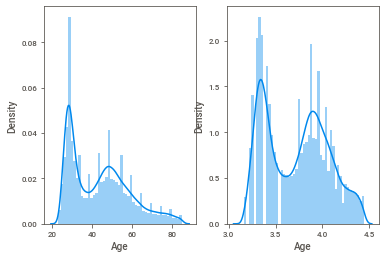

In [89]:

fig, ax = plt.subplots(1, 2)
sns.distplot(train_df.Age,ax=ax[0])
sns.distplot(np.log(train_df.Age),ax=ax[1])
plt.show()

C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


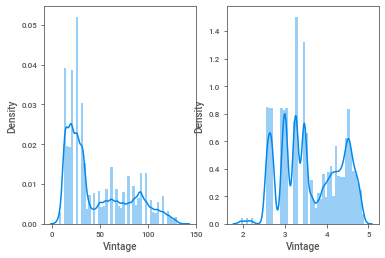

In [90]:

fig, ax = plt.subplots(1, 2)
sns.distplot(train_df.Vintage,ax=ax[0])
sns.distplot(np.log(train_df.Vintage),ax=ax[1])
plt.show()

C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


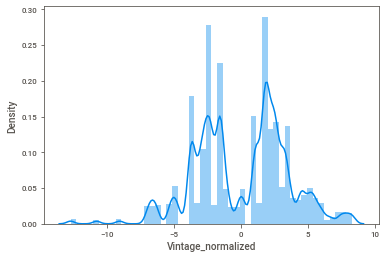

In [161]:
sns.distplot(final_train_df.Vintage_normalized)
plt.show()

C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


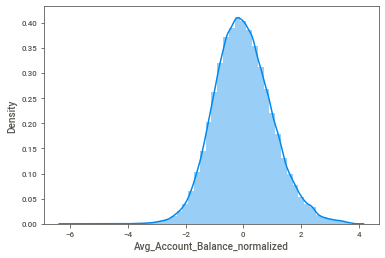

In [164]:
sns.distplot(final_train_df.Avg_Account_Balance_normalized)
plt.show()

C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


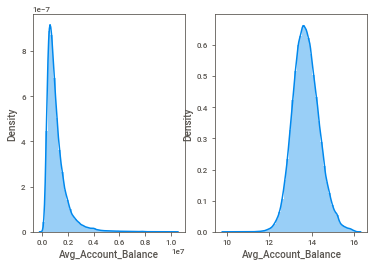

In [93]:

fig, ax = plt.subplots(1, 2)
sns.distplot(train_df.Avg_Account_Balance,ax=ax[0])
sns.distplot(np.log(train_df.Avg_Account_Balance),ax=ax[1])
plt.show()

C:\Users\RG\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Vintage', ylabel='Density'>

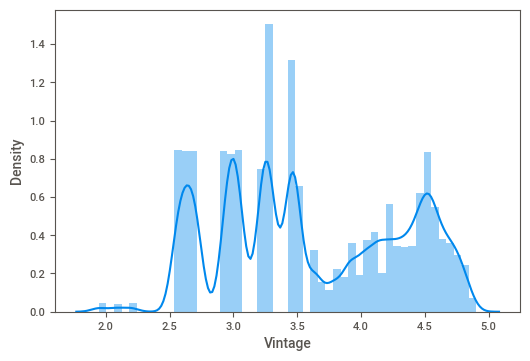

In [79]:
# sns.distplot(train_df.Vintage)
sns.distplot(np.log(train_df.Vintage))